# Quantum Convolutional Neural Network
# ICLR 2020 Submission
### by Jonas Landman
PhD Student, Université Paris Diderot. landman@irif.fr

Implement in PyTorch a CNN that mimics the behavior of a Quantum CNN (QCNN), with a modified training (Quantum Backpropagation), and modified forward pass (probabilistic sampling, error introduction)


In [2]:
epsilon_RANGE = [0.01]
Cap_RANGE = [2]
ratio_RANGE = [0.5]
BackpErr_RANGE = [0.1]

#### imports
need to install PyTorch, see https://pytorch.org/get-started/locally/

need pandas, do `$ pip install pandas`

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.distributions import Categorical
from torchvision.transforms import Resize
import torch.optim as optim
from torch.optim import Optimizer # 'required' was removed here


import matplotlib.image as img
import scipy
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

import time
import csv
import pandas as pd


In [4]:
%pylab inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

rc('text', usetex=True)


params = {'legend.fontsize': 50,
          'legend.handlelength': 3,
          'figure.figsize':(25, 15),
         }

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 60}
matplotlib.rc('font', **font)
pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


##### Define a global path to store results

In [5]:
path = '/content/untitled'

##### Define key parameters for training

In [6]:
n_epochs = 2
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0 #0 because it's nowhere in our paper
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

##### Import MNIST dataset

In [7]:
transform_mnist = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset_mnist = torchvision.datasets.MNIST(
    root="./data-mnist",
    train=True,
    download=True,   # ← 여기만 True
    transform=transform_mnist
)
trainloader_mnist = torch.utils.data.DataLoader(
    trainset_mnist, batch_size=batch_size_train, shuffle=True, num_workers=2
)

testset_mnist = torchvision.datasets.MNIST(
    root="./data-mnist",
    train=False,
    download=True,   # ← 여기만 True
    transform=transform_mnist
)
testloader_mnist = torch.utils.data.DataLoader(
    testset_mnist, batch_size=batch_size_test, shuffle=False, num_workers=2
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 19.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.82MB/s]


##### Define train and test function
They should store values in specific .csv file, and log messages

In [8]:
def train(epoch, train_loader, network, name, path, optimizer):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),end='\r')
            train_losses.append(loss.item())
            train_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), path+'model_'+name+'.pth')
            torch.save(optimizer.state_dict(), path+'optimizer_'+name+'.pth')
            df = pd.DataFrame({'losses': train_losses,
                               'counter': train_counter})
            df.to_csv(path+'traincurve_'+name+'.csv')


def train_from_middle(epoch, train_loader, network, name, path, optimizer, number_current_logs):
    '''Train from a pretrained network!'''
    total_expected_logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
    current_batch_idx = number_current_logs*log_interval - 94*(epoch-1)*log_interval #remove batch_idx from other epochs (94 logs per epoch it seems)
    print('current_batch_idx:',current_batch_idx)
    network.train()
    ###################
    # need to start the training at the first batch, but at batch n° current_batch_idx
    # if batch_idx < current_batch_idx, skip. And when batch_idx = current_batch_idx, start realy training
    ###################
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx < current_batch_idx:
            continue
            #print('batch_idx:',batch_idx,' < current_batch_idx...')
        else:
            #print('batch_idx:',batch_idx,' >= current_batch_idx!  TRAIN')
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()),end='\r')
                train_losses.append(loss.item())
                train_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
                torch.save(network.state_dict(), path+'model_'+name+'.pth')
                torch.save(optimizer.state_dict(), path+'optimizer_'+name+'.pth')
                df = pd.DataFrame({'losses': train_losses,
                                   'counter': train_counter})
                df.to_csv(path+'traincurve_'+name+'.csv')



def test(test_loader, network):
    network.eval()
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():
        for data, target in test_loader:
            print('batch n°',i,'/',len(test_loader),'...',end='\r')
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            i+=1

    test_loss /= len(test_loader.dataset)
    #test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100* float(correct) / float(len(test_loader.dataset))),end='\r')
    return test_loss


### Stochastic Gradient Descent implementation : Quantum & Classical

In [9]:
class Quantum_SGD(Optimizer):
    def __init__(self, params, lr=0, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, noise=0): # Here we have added the 'noise' parameter (set 0 by default)
        if lr < 0.0: # 'required' was removed here
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if noise < 0.0:
            raise ValueError("Invalid noise value: {}".format(noise))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay,
                        nesterov=nesterov, noise=noise) # Here we have added the 'noise' parameter
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(Quantum_SGD, self).__init__(params, defaults)
    def __setstate__(self, state):
        super(Quantum_SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
    def step(self, closure=None):
        """Performs a single optimization step.
            HERE WE ADD THE QUANTUM NOISE!
            implement as relative error (l2 norm)
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            noise = group['noise'] # Here we have added the 'noise' parameter
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                # Classical update rule p = p +(-learning_rate)*p.grad
                # now changed to quatnum
                # WITH RELATIVE ERROR
                # where noise_tensor is a tensor of shape p.shape,
                # noise_tensor has random values distributed as gaussian with std = noise
                noise_tensor = p.shape
                noise_tensor = torch.Tensor(p.data.new(p.size()).normal_(0, noise))
                #noisy grad entry (i,j) should be grad_ij+noise_ij)*norm_l2(grad)
                norml2_dp = torch.norm(d_p)
                noisy_grad = torch.add(d_p , norml2_dp*noise_tensor)
                #update of parameters
                p.data.add_(-group['lr'], noisy_grad)
        return loss



class Classical_SGD(Optimizer):
    def __init__(self, params, lr=0, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(Classical_SGD, self).__init__(params, defaults)
    def __setstate__(self, state):
        super(Classical_SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
    def step(self, closure=None):
        """Performs a single optimization step.
            HERE WE DON'T HAVE THE QUANTUM NOISE
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                #update the parameters
                p.data.add_(-group['lr'], d_p)
        return loss

## Classical CNN / Training

##### Define the network

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=7)
        self.conv2 = nn.Conv2d(5,10, kernel_size=7)
        self.fc1 = nn.Linear(2560, 300)
        self.fc2 = nn.Linear(300, 50)
        self.fc3 = nn.Linear(50, 10)
        #self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)



    def activation_function_ReLu(self,input_tensor):
        output_tensor = torch.clamp(input_tensor, min=0)
        return output_tensor


    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.activation_function_ReLu(x)
        #x = self.pooling(x)
        #print(x.shape)

        x = self.conv2(x)
        x = self.activation_function_ReLu(x)
        #x = self.pooling(x)
        #print(x.shape)

#         x = self.conv3(x)
#         x = self.activation_function_ReLu(x)

        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x

##### Train the network

In [11]:
network = CNN()
optimizer = Classical_SGD(network.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader_mnist.dataset) for i in range(n_epochs + 1)]

#name
name = "CNN"

#run several train on the whole dataset, and test each time at the end
for epoch in range(1, n_epochs + 1):
    print("Epoch #",epoch)
    train(epoch, trainloader_mnist, network, name, path, optimizer)

print('\nFINISH TRAINING', n_epochs, 'EPOCHS')
torch.save(network.state_dict(), path+name+'.pth')

# ✅ 학습 종료 후 테스트 정확도 계산
network.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, target in testloader_mnist:
        output = network(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

acc = 100. * correct / total
print(f"\n🎯 Final QFCNN Test Accuracy: {acc:.2f}% ({correct}/{total})\n")

# ✅ 추가: 네트워크 파라미터 수 출력
num_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print(f"🧠 Trainable Parameters: {num_params:,d}\n")


Epoch # 1


/tmp/ipython-input-1054795736.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))
/tmp/ipython-input-1817537261.py:117: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
  p.data.add_(-group['lr'], d_p)


Epoch # 2
Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.054152
FINISH TRAINING 2 EPOCHS

🎯 Final QFCNN Test Accuracy: 95.78% (9578/10000)

🧠 Trainable Parameters: 786,570



/tmp/ipython-input-2640555106.py:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_params = sum(p.numel() for p in network.parameters() if p.requires_grad)


##### Show test set accuracy and plot learning curve

test


/tmp/ipython-input-1054795736.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))
/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


batch n° 9 / 10 ...
Test set: Avg. loss: 0.1313, Accuracy: 9578/10000 (95.78%)

train


batch n° 937 / 938 ...
Test set: Avg. loss: 0.1307, Accuracy: 57624/60000 (96.04%)


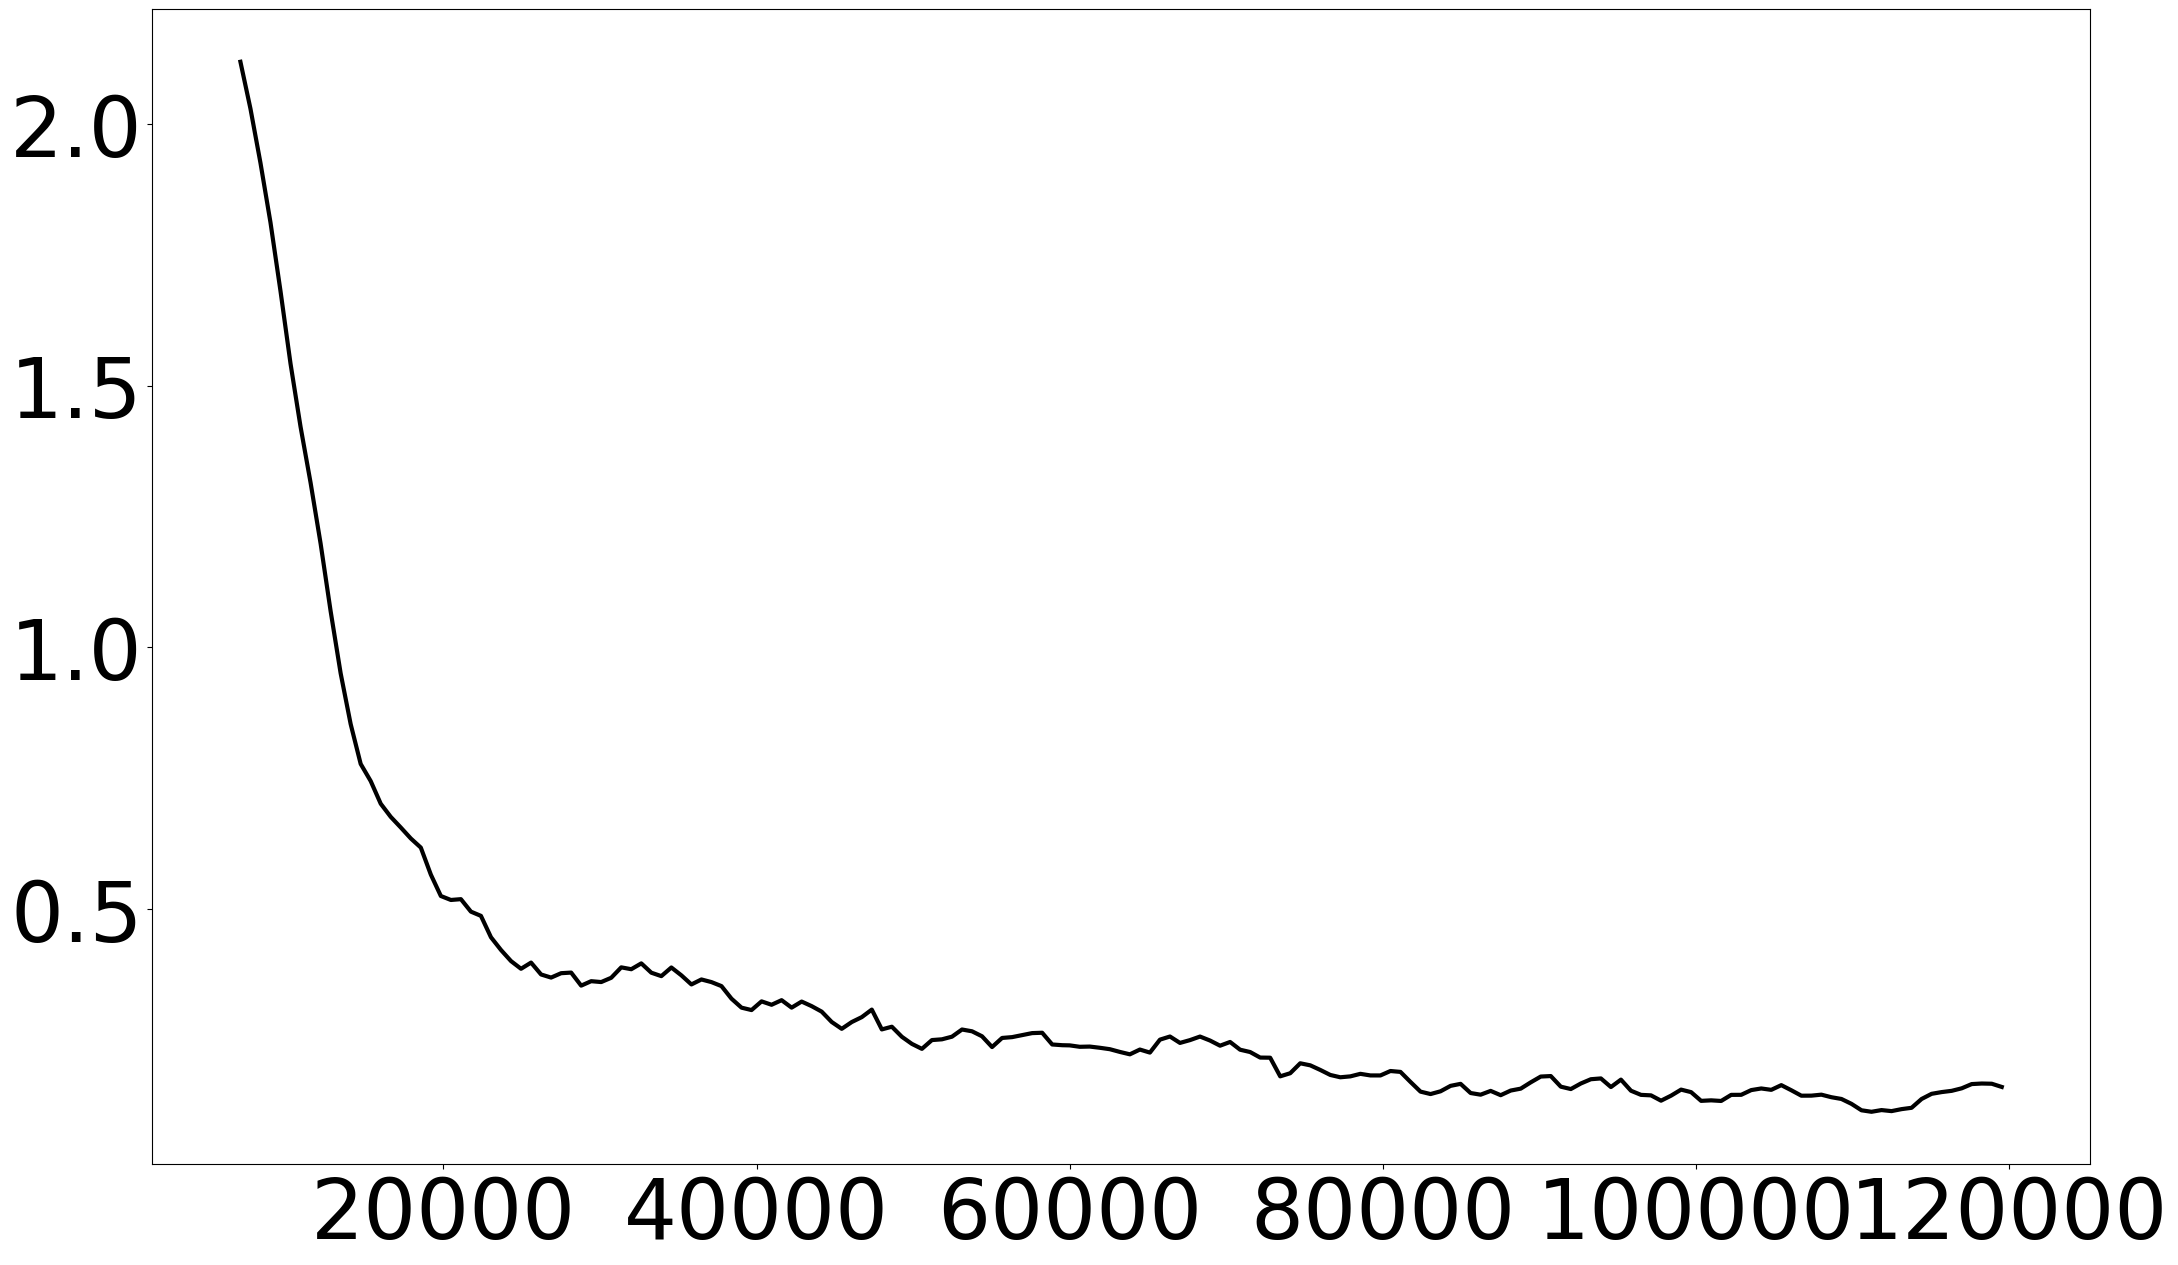

In [12]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


print('test')
test(testloader_mnist, network)
print('\ntrain')
test(trainloader_mnist, network)

df_train = pd.DataFrame()
df_train[name] = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
#df_train['rollmean_'+name] = pd.rolling_mean(df_train[name], window=12)
df_train['rollmean_'+name] = df_train[name].rolling(window=12).mean()
plt.plot(df_train['rollmean_CNN'], color='black', label='CNN', linewidth=3)
plt.show()

# QCNN


##### Define set of values for key quantum parameters
- epsilon_RANGE = $\epsilon$
- Cap_RANGE = $T$
- ratio_RANGE = $\sigma$
- BackpErr_RANGE = $\delta$

##### A loop that define and train QCNN for each combination of parameters

In [13]:
for BackpErr in BackpErr_RANGE:
    for Cap in Cap_RANGE:
        for ratio in ratio_RANGE:
            for epsilon in epsilon_RANGE:
                time0 = time.time()
                print('\n\n********** ratio:',ratio,'**********')
                print('********** BackpErr:',BackpErr,'**********')
                print('********** epsilon:',epsilon,'********')
                print('********** Cap:',Cap,'**************')

                            # 1 -  list to store important values
                    #layer 1
                M_list_1 = []
                Average_list_1 = []
                F_mu_list_1 = []
                A_mu_list_1 = []
                    #layer 2
                M_list_2 = []
                Average_list_2 = []
                F_mu_list_2 = []
                A_mu_list_2 = []



                            # 2 -  define the QCNN
                class QCNN(nn.Module):
                    def __init__(self):
                        super(QCNN, self).__init__()
                        self.conv1 = nn.Conv2d(1, 5, kernel_size=7)
                        self.conv2 = nn.Conv2d(5, 10, kernel_size=7)
                        self.fc1 = nn.Linear(2560, 300)
                        self.fc2 = nn.Linear(300, 50)
                        self.fc3 = nn.Linear(50, 10)

                    def activation_function_CapReLu(self,input_tensor, Cap):
                        output_tensor = torch.clamp(input_tensor, min=0, max=Cap)
                        return output_tensor

                    def get_norm_matrix(self, input_tensor, conv): # conv should be self.conv1 for instance
                        """Calculate the norm of A_p and F_q, but also the mu(A) and mu(F)"""
                        kernel = conv.weight.data
                        h = kernel.shape[2]
                        w = kernel.shape[3]
                        H = input_tensor.shape[2]
                        W = input_tensor.shape[3]
                        # 0: prepare matrices
                        F = []
                        A = []
                        # 1: F_q norm calculations (kernel)
                        kernels_norms = []
                        for q in range(len(kernel)): #for each channels q
                            Fq = kernel[q]
                            kernels_norms.append(torch.norm(Fq).numpy())#add the norm of F_q to the list of norms
                            Fq = Fq.detach().numpy().flatten()
                            F.append(Fq) #add the column F_q to the matrix F
                        kernels_norms = np.array(kernels_norms)
                        F = np.array(F).transpose()
                        # 2: A_p norm calculations (input)
                        input_norms = []
                        for i in range(H-h+1):
                            for j in range(W-w+1): #for each 'kernel' subregion in the input
                                Ap = input_tensor[0,0,0+i:h+i,0+j:w+j] #selected subregion
                                norm_p = torch.norm(Ap)
                                input_norms.append(norm_p.detach().numpy().flatten()) #add the norm of A_p to the list of norms
                                Ap = Ap.detach().numpy().flatten() #transform as numpy vector
                                A.append(Ap) #add the row A_p to the matrix A
                        input_norms = np.array(input_norms)
                        A = np.array(A)
                        # 3: calculate mu=(Frob norm / Spectral norm)
                        F_mu = np.linalg.norm(F, 'fro')/np.linalg.norm(F, 2)
                        A_mu = np.linalg.norm(A, 'fro')/np.linalg.norm(A, 2)
                        # 4: calculate the matrix of ||Ap||*||Fq||
                        norm_matrix_output = np.outer(input_norms, kernels_norms) #we create the matrix of ||Ap||*||Fq||
                        return norm_matrix_output, F_mu, A_mu

                    def add_gaussian_noise(self, input_tensor, epsilon, norm_matrix):
                        #norm_matrix is a matrix of ||Ap||*||Fq||
                        #the noise matrix is gaussian values centered on 0 and with std deviation of epsilon
                        #output = input +2*noise*||Ap||*||Fq||
                        noise = torch.Tensor(input_tensor.data.new(input_tensor.size()).normal_(0, epsilon))
                        norms_tensor = np.reshape(norm_matrix.transpose(),
                                                  (1,input_tensor.shape[1],input_tensor.shape[2],input_tensor.shape[3]))
                        norms_tensor = torch.from_numpy(norms_tensor) #it was a numpy object
                        output_tensor = input_tensor + 2*torch.mul(noise, norms_tensor, out=None) #torch.mul : entrywise multiplication noise*||Ap||*||Fq||
                        output_tensor = torch.clamp(output_tensor, min=0, max=Cap) #no value should be less than 0 or more than Cap!
                        return output_tensor

                    def quantum_sampling(self, input_tensor, ratio):
                        output_tensor = torch.zeros_like(input_tensor)
                        num_samples = int(ratio*input_tensor[0].numel()) # ratio x number of elements in each tensor of the batch
                        for i in range(input_tensor.shape[0]): #for each tensor in the batch
                            x = input_tensor[i] # tensor n°i
                            x_vec = x.flatten() # vectorize
                            probabilities = x_vec #quantum sampling
                            m = Categorical(probs=probabilities) # create the torch function to sample with probability distribution = x_vec
                            sample_index = m.sample((num_samples,)) #sample num_samples times
                            y = torch.zeros(x_vec.shape) # create zeros vector of same length
                            y[sample_index] = 1 # this is the mask
                            out = x_vec*y # apply mask
                            out = out.reshape(x.shape) # reshape to initial tensor
                            output_tensor[i] = out
                        return output_tensor

                    def calculate_average(self, input_tensor):
                        average = torch.mean(input_tensor)
                        return average.detach().numpy()

                    def forward(self, x):

                        #LAYER1
                        #1: stats and matrix values
                        norm_matrix_1, F_mu_1, A_mu_1= self.get_norm_matrix(x, self.conv1) # norm_matrix will be used in add_gaussian_noise later
                        M_list_1.append(np.max(norm_matrix_1)) # needed for stat: max of the norm_matrix
                        F_mu_list_1.append(F_mu_1)
                        A_mu_list_1.append(A_mu_1)
                                # #1.5: Plot
                                #plt.imshow(x[0,0,:,:].detach().numpy(),cmap='gray')
                                #plt.show()
                        #2:operations
                        x = self.conv1(x) #first convolution
                        x = self.activation_function_CapReLu(x,Cap) #caprelu
                        x = self.add_gaussian_noise(x,epsilon,norm_matrix_1) #a.e. noise (with multiplicative norms)
                        x = self.quantum_sampling(x, ratio) #quantum sampling
                        #3:stats
                        Average_list_1.append(self.calculate_average(x))

                        #LAYER2
                        norm_matrix_2, F_mu_2, A_mu_2 = self.get_norm_matrix(x, self.conv2) # will be used in add_gaussian_noise later
                        M_list_2.append(np.max(norm_matrix_2)) # needed for stat: max of the norm_matrix
                        F_mu_list_2.append(F_mu_2)
                        A_mu_list_2.append(A_mu_2)
                        x = self.conv2(x)
                        x = self.activation_function_CapReLu(x,Cap)
                        x = self.add_gaussian_noise(x,epsilon,norm_matrix_2)
                        x = self.quantum_sampling(x, ratio)
                        Average_list_2.append(self.calculate_average(x))

                        #Fully connected Layer
                        x = x.view(x.shape[0],-1)
                        x = F.relu(self.fc1(x))
                        x = F.relu(self.fc2(x))
                        x = F.log_softmax(self.fc3(x))

                        #save stats: M, mu(F), mu(A) and Average layer
                        df_ = pd.DataFrame({'M_list_1': M_list_1,
                                            'Average_list_1': Average_list_1,
                                            'F_mu_list_1':F_mu_list_1,
                                            'A_mu_list_1':A_mu_list_1,
                                            'M_list_2': M_list_2,
                                            'Average_list_2': Average_list_2,
                                            'F_mu_list_2':F_mu_list_2,
                                            'A_mu_list_2':A_mu_list_2,})
                        df_.to_csv(path+'_values_'+name+'.csv')

                        return x




                #name
                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)

                                # 3  -  Three possible cases to not train what was already trained
                #CASE 1 : do not run if the combinaison of parameters have already been done!
                if os.path.isfile((path+name+'.pth')):
                    print("---->ALREADY COMPUTED<----")
                    print('# of logs:',len(pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']),'\n')


                #CASE 2 : if the training was stopped in the middle, retrain from checkpoint
                elif os.path.isfile((path+'model_'+name+'.pth')):
                    print("----> RETRAIN FROM CHECKPOINT <----\n")
                    continued_network = QCNN()
                    Quantum_optimizer = Quantum_SGD(continued_network.parameters(), lr=learning_rate, noise=BackpErr)
                    #load network state
                    network_state_dict = torch.load(path+'model_'+name+'.pth')
                    continued_network.load_state_dict(network_state_dict)
                    #load optimizer state
                    optimizer_state_dict = torch.load(path+'optimizer_'+name+'.pth')
                    Quantum_optimizer.load_state_dict(optimizer_state_dict)
                    #load traincurve info
                    df_traincurve = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
                    train_losses = list(np.array(df_traincurve))
                    train_counter = list(np.array(df_traincurve.index))
                    #how many epochs need to be run?
                    #in total must be 188 logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
                    total_expected_logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
                    number_current_logs = len(df_traincurve)
                    current_epoch = int((number_current_logs // (total_expected_logs/n_epochs)) + 1)
                    # ------ TRAIN from middle of the epoch------
                    for epoch in range(current_epoch, n_epochs + 1):
                        print("\nEpoch n°",epoch)
                        if epoch == current_epoch: #current epoch: start at the current log
                            print("Start from middle, at batch n°",number_current_logs*log_interval)
                            train_from_middle(epoch, trainloader_mnist, continued_network, name, path, Quantum_optimizer, number_current_logs)
                            print('\nTIME:',round((time.time()-time0)/60,2),'min')
                        if epoch > current_epoch: #next epochs: start from beggining
                            print("Start at the beginning")
                            train(epoch, trainloader_mnist, continued_network, name, path, Quantum_optimizer)
                            print('\nTIME:',round((time.time()-time0)/60,2),'min')
                    # Save the network - occurs only when it's all finished (important)
                    print('\nFINISH TRAINING',n_epochs,'EPOCHS')
                    torch.save(continued_network.state_dict(), path+name+'.pth')



                #CASE 3 :  if it's a new training!
                else:
                    print("---->NEW TRAINING<----\n")
                    network = QCNN()
                    Quantum_optimizer = Quantum_SGD(network.parameters(), lr=learning_rate, noise=BackpErr)
                    train_losses = []
                    train_counter = []
                    #current epoch is the first one
                    current_epoch = 1
                    # ------ TRAIN from beggining------
                    for epoch in range(current_epoch, n_epochs + 1):
                        print("\nEpoch #",epoch)
                        train(epoch, trainloader_mnist, network, name, path, Quantum_optimizer) #only train
                        print('\nTIME:',round((time.time()-time0)/60,2),'min')
                    # Save the network - occurs only when it's all finished (important)
                    print('\nFINISH TRAINING',n_epochs,'EPOCHS')
                    torch.save(network.state_dict(), path+name+'.pth')
print('\nFINISH TRAINING', n_epochs, 'EPOCHS')
torch.save(network.state_dict(), path+name+'.pth')

# ✅ 학습 종료 후 테스트 정확도 계산
network.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, target in testloader_mnist:
        output = network(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

acc = 100. * correct / total
print(f"\n🎯 Final QCNN Test Accuracy: {acc:.2f}% ({correct}/{total})\n")

# ✅ 추가: 네트워크 파라미터 수 출력
num_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print(f"🧠 Trainable Parameters: {num_params:,d}\n")

print('\n **DONE**')




********** ratio: 0.5 **********
********** BackpErr: 0.1 **********
********** epsilon: 0.01 ********
********** Cap: 2 **************
---->NEW TRAINING<----


Epoch # 1


/tmp/ipython-input-2776462925.py:142: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))



TIME: 3.06 min

Epoch # 2

TIME: 6.4 min

FINISH TRAINING 2 EPOCHS

FINISH TRAINING 2 EPOCHS

🎯 Final QCNN Test Accuracy: 91.51% (9151/10000)

🧠 Trainable Parameters: 786,570


 **DONE**


/tmp/ipython-input-2776462925.py:241: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_params = sum(p.numel() for p in network.parameters() if p.requires_grad)


### Plot Learning curves

In [14]:

"""
#load training data

all_data = pd.DataFrame()

window = 12
name_list = []
i=0

for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:
                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)
                if os.path.isfile((path+'traincurve_'+name+'.csv')): #the file is here = the combinaison has been tried
                    i+=1
                    name_list.append(name)
                    df_train = pd.DataFrame()
                    df_train[name] = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
                    print(name, df_train[name].shape)
                    #df_train['rollmean_'+name] = pd.rolling_mean(df_train[name], window=window)
                    #df_train['rollstd_'+name] = pd.rolling_std(df_train[name], window=window)
                    df_train['rollmean_'+name] = df_train[name].rolling(window=window).mean()
                    df_train['rollstd_'+name] = df_train[name].rolling(window=window).std()
                    all_data = pd.concat([all_data, df_train], axis=1)

# Compare to classical CNN
df_train = pd.DataFrame()
name = 'CNN'
df_train[name] = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
#df_train['rollmean_'+name] = pd.rolling_mean(df_train[name], window=window)
#df_train['rollstd_'+name] = pd.rolling_std(df_train[name], window=window)
df_train['rollmean_'+name] = df_train[name].rolling(window=window).mean()
df_train['rollstd_'+name] = df_train[name].rolling(window=window).std()
all_data = pd.concat([all_data, df_train], axis=1)

print("\n----",i,'EXPERIMENTS ----')
"""

'\n#load training data\n\nall_data = pd.DataFrame()\n\nwindow = 12\nname_list = []\ni=0\n\nfor ratio in ratio_RANGE:\n    for Cap in Cap_RANGE:\n        for epsilon in epsilon_RANGE:\n            for BackpErr in BackpErr_RANGE:\n                name = \'QCNN_ratio-\'+str(ratio)+\'_epsilon-\'+str(epsilon)+\'_Cap-\'+str(Cap)+\'_BackpErr_\'+str(BackpErr)\n                if os.path.isfile((path+\'traincurve_\'+name+\'.csv\')): #the file is here = the combinaison has been tried\n                    i+=1\n                    name_list.append(name)\n                    df_train = pd.DataFrame()\n                    df_train[name] = pd.read_csv(path+\'traincurve_\'+name+\'.csv\',index_col=\'counter\')[\'losses\']\n                    print(name, df_train[name].shape)\n                    #df_train[\'rollmean_\'+name] = pd.rolling_mean(df_train[name], window=window)\n                    #df_train[\'rollstd_\'+name] = pd.rolling_std(df_train[name], window=window)\n                    df_train[\

In [15]:
"""
#plot with color

plt.figure(figsize=(25, 15))

plt.plot(all_data['rollmean_CNN'], color='black', label='CNN', linewidth=4)
for count, name in enumerate(name_list):
    label_split=name.split('_')
    ratio = float((label_split[1].split('-'))[1])
    epsilon = float((label_split[2].split('-'))[1])
    cap = float((label_split[3].split('-'))[1])
    BackprErr = float((label_split[5]))
    label = label_split[0]+': $\sigma$='+str(ratio)#+', $\epsilon$='+str(epsilon)+', cap='+str(cap)+', BackprErr='+str(BackprErr)

    color = plt.cm.get_cmap('hsv', 30)
    plt.plot(all_data['rollmean_'+name], color=color(2*count), label=label, linewidth=4)

    plt.legend(loc='upper right')
    plt.title('Training curves for $\epsilon$={}, C={}, $\delta$={}'.format(epsilon,cap,BackprErr))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()


fname = 'training_epsilon{}_T{}_delta{}'.format(epsilon,int(cap),BackprErr)
plt.savefig('./images/'+fname.replace('.','')+'.png')
plt.show(block=False)



#plot without color

plt.figure(figsize=(25, 15))

plt.plot(all_data['rollmean_CNN'], color='black', label='CNN', linewidth=4)
for count, name in enumerate(name_list):
    label_split=name.split('_')
    ratio = float((label_split[1].split('-'))[1])
    epsilon = float((label_split[2].split('-'))[1])
    cap = float((label_split[3].split('-'))[1])
    BackprErr = float((label_split[5]))
    label = label_split[0]+': $\sigma$='+str(ratio)#+', $\epsilon$='+str(epsilon)+', cap='+str(cap)+', BackprErr='+str(BackprErr)

    LINESTYLE = ["-",":",(0, (3, 1, 1, 1)),"--",'-.']
    plt.plot(all_data['rollmean_'+name], color='red', label=label, linewidth=4, linestyle=LINESTYLE[count%len(LINESTYLE)]) #color=color(count)

    plt.legend(loc='upper right')
    plt.title('Training curves for $\epsilon$={}, C={}, $\delta$={}'.format(epsilon,cap,BackprErr))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()


fname = 'training_epsilon{}_T{}_delta{}_unicolor'.format(epsilon,int(cap),BackprErr)
plt.savefig('./images/'+fname.replace('.','')+'.png')
plt.show(block=False)
"""


<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2657082559.py:13: SyntaxWarning: invalid escape sequence '\s'
  label = label_split[0]+': $\sigma$='+str(ratio)#+', $\epsilon$='+str(epsilon)+', cap='+str(cap)+', BackprErr='+str(BackprErr)


'\n#plot with color\n\nplt.figure(figsize=(25, 15))\n\nplt.plot(all_data[\'rollmean_CNN\'], color=\'black\', label=\'CNN\', linewidth=4)\nfor count, name in enumerate(name_list):\n    label_split=name.split(\'_\')\n    ratio = float((label_split[1].split(\'-\'))[1])\n    epsilon = float((label_split[2].split(\'-\'))[1])\n    cap = float((label_split[3].split(\'-\'))[1])\n    BackprErr = float((label_split[5]))\n    label = label_split[0]+\': $\\sigma$=\'+str(ratio)#+\', $\\epsilon$=\'+str(epsilon)+\', cap=\'+str(cap)+\', BackprErr=\'+str(BackprErr)\n\n    color = plt.cm.get_cmap(\'hsv\', 30)\n    plt.plot(all_data[\'rollmean_\'+name], color=color(2*count), label=label, linewidth=4)\n\n    plt.legend(loc=\'upper right\')\n    plt.title(\'Training curves for $\\epsilon$={}, C={}, $\\delta$={}\'.format(epsilon,cap,BackprErr))\n    plt.xlabel(\'Iterations\')\n    plt.ylabel(\'Loss\')\n    plt.grid()\n\n\nfname = \'training_epsilon{}_T{}_delta{}\'.format(epsilon,int(cap),BackprErr)\nplt.sav

# QFCNN


In [16]:
class FourierConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=True):
        super(FourierConv2D, self).__init__()

        self.kernel = nn.Parameter(
            data=torch.Tensor(out_channels, in_channels, kernel_size, kernel_size),
            requires_grad=True
        )
        self.kernel.data.uniform_(-0.1, 0.1)

        # nn.Conv2d 호환성 유지
        self.weight = self.kernel

        if bias:
            self.bias = nn.Parameter(data=torch.Tensor(out_channels), requires_grad=True)
            self.bias.data.zero_()
        else:
            self.bias = None

        self.out_channels, self.in_channels, self.kernel_size = out_channels, in_channels, kernel_size

class FourierConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=True):
        super(FourierConv2D, self).__init__()
        self.kernel = nn.Parameter(
            torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)
        )
        self.kernel.data.uniform_(-0.1, 0.1)
        self.weight = self.kernel
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None
        self.out_channels, self.in_channels, self.kernel_size = out_channels, in_channels, kernel_size

    def forward(self, img, epsilon=0.01):
        bs, _, h, w = img.size()
        new_h, new_w = h + self.kernel_size - 1, w + self.kernel_size - 1
        pad_h, pad_w = (new_h - h) // 2, (new_w - w) // 2

        new_img = F.pad(img, (pad_w, pad_w, pad_h, pad_h), mode='constant', value=0)
        new_kernel = torch.zeros(
            [self.out_channels, self.in_channels, new_h, new_w],
            device=self.kernel.device
        )

        k_center = self.kernel_size // 2
        ky, kx = torch.meshgrid(
            torch.arange(self.kernel_size),
            torch.arange(self.kernel_size),
            indexing='ij'
        )
        kny = (ky.flip(0) - k_center) % new_h
        knx = (kx.flip(1) - k_center) % new_w
        new_kernel[..., kny, knx] = self.kernel[..., ky, kx]

        # ✅ QFT 시뮬레이션 단계
        new_img_fft = torch.fft.fft2(new_img)
        new_kernel_fft = torch.fft.fft2(torch.transpose(new_kernel, 0, 1))

        # ✅ Shen et al. (2021)에서 말한 Quantum Noise 추가
        if epsilon > 0:
            noise_real_img = torch.randn_like(new_img_fft.real) * epsilon
            noise_imag_img = torch.randn_like(new_img_fft.imag) * epsilon
            new_img_fft = new_img_fft + (noise_real_img + 1j * noise_imag_img)

            noise_real_kernel = torch.randn_like(new_kernel_fft.real) * epsilon
            noise_imag_kernel = torch.randn_like(new_kernel_fft.imag) * epsilon
            new_kernel_fft = new_kernel_fft + (noise_real_kernel + 1j * noise_imag_kernel)

        # ✅ FFT 기반 convolution
        res_fft = torch.zeros(
            bs, self.out_channels, new_h, new_w,
            dtype=torch.complex64, device=img.device
        )
        for i in range(self.in_channels):
            res_fft += new_img_fft[:, i, ...].unsqueeze(1) * new_kernel_fft[i, ...].unsqueeze(0)

        res = torch.fft.ifft2(res_fft).real

        if pad_h > 0 and pad_w > 0:
            res = res[..., pad_h:-pad_h, pad_w:-pad_w]
        if self.bias is not None:
            res += self.bias.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        return res





'''
    Spectral pooling layer
'''
class SpectralPooling2d(nn.Module):
    def __init__(self, kernel_size):
        super(SpectralPooling2d, self).__init__()

        self.kernel_size = 2

    def crop_spectrum(self, z, H, W):
        '''
            z: [bs, c, M, N, 2]
            Return: [bs, c, H, H, 2]
        '''
        M, N = z.size(-3), z.size(-2)
        return z[..., M//2-H//2:M//2+H//2, N//2-W//2:N//2+W//2, :]

    def pad_spectrum(self, z, M, N):
        '''
            z: [bs, c, H, W, 2]
            Return: [bs, c, M, N, 2]
        '''
        H, W = z.size(-3), z.size(-2)
        z_real, z_imag = z[..., 0], z[..., 1]
        pad = torch.nn.ZeroPad2d((N-W)//2, (N-W)//2, (M-H)//2, (M-H)//2)
        return torch.stack([pad(z_real), pad(z_imag)], dim = -1)

    def treat_corner_cases(self, freq_map):
        '''
            freq_map: [bs, c, M, N, 2]
        '''
        S = [(0, 0)]
        M, N = freq_map.size(-3), freq_map.size(-2)

        if M % 2 == 1:
            S.append((M // 2, 0))
        if N % 2 == 1:
            S.append((0, N // 2))
        if M % 2 == 1 and N % 2 == 1:
            S.append((M // 2, N // 2))

        for h, w in S:
            freq_map[..., h, w, 1].zero_()

        return freq_map, S

    def remove_redundancy(self, y):
        '''
            y: input gradient map [bs, c, M, N, 2]
        '''
        z, S = self.treat_corner_cases(y)
        I = []
        M, N = y.size(-3), y.size(-2)

        for m in range(M):
            for n in range(N // 2 + 1):
                if (m, n) not in S:
                    if (m, n) not in I:
                        z[..., m, n, :].mul_(2)
                        I.append((m, n))
                        I.append(((M - m) % M, (N - n) % N))
                    else:
                        z[..., m, n, :].zero_()

        return z

    def recover_map(self, y):
        z, S = self.treat_corner_cases(y)
        I = []
        M, N = y.size(-3), y.size(-2)

        for m in range(M):
            for n in range(N // 2 + 1):
                if (m, n) not in S:
                    if (m, n) not in I:
                        z[..., m, n, :].mul_(0.5)
                        z[..., (M-m)%M, (N-n)%N] = z[..., m, n, :]
                        I.append((m, n))
                        I.append(((M - m) % M, (N - n) % N))
                    else:
                        z[..., m, n, :].zero_()

        return z

    def forward(self, x):
        M, N = x.size(-2), x.size(-1)
        H, W = M // self.kernel_size, N // self.kernel_size

        x_fft = torch.rfft(x, 2, onesided = False)
        crop_x_fft = self.crop_spectrum(x_fft, H, W)
        crop_x_fft, _ = self.treat_corner_cases(crop_x_fft)
        pool_x = torch.irfft(crop_x_fft, 2, onesided = False)
        return pool_x

    def backward(self, gRgx):
        H, W = gRgx.size(-2), gRgx.size(-1)
        M, N = H * self.kernel_size, W * self.kernel_size

        z = torch.rfft(gRgx, 2, onesided = False)
        z = self.remove_redundancy(z)
        z = self.pad_spectrum(z, M, N)
        z = self.recover_map(z)
        gRx = torch.irfft(z, 2, onesided = False)

        return gRx

for BackpErr in BackpErr_RANGE:
    for Cap in Cap_RANGE:
        for ratio in ratio_RANGE:
            for epsilon in epsilon_RANGE:
                time0 = time.time()
                print('\n\n********** ratio:',ratio,'**********')
                print('********** BackpErr:',BackpErr,'**********')
                print('********** epsilon:',epsilon,'********')
                print('********** Cap:',Cap,'**************')

                            # 1 -  list to store important values
                    #layer 1
                M_list_1 = []
                Average_list_1 = []
                F_mu_list_1 = []
                A_mu_list_1 = []
                    #layer 2
                M_list_2 = []
                Average_list_2 = []
                F_mu_list_2 = []
                A_mu_list_2 = []



                            # 2 -  define the QFCNN
                class QFCNN(nn.Module):
                    def __init__(self):
                        super(QFCNN, self).__init__()
                        self.conv1 = FourierConv2D(1, 5, kernel_size=7)
                        self.conv2 = FourierConv2D(5, 10, kernel_size=7)
                        self.fc1 = nn.Linear(7840, 300)

                        self.fc2 = nn.Linear(300, 50)
                        self.fc3 = nn.Linear(50, 10)

                    def activation_function_CapReLu(self,input_tensor, Cap):
                        output_tensor = torch.clamp(input_tensor, min=0, max=Cap)
                        return output_tensor

                    def get_norm_matrix(self, input_tensor, conv):
                        """Calculate the norm of A_p and F_q, but also the mu(A) and mu(F)"""
                        kernel = conv.kernel.data              # FourierConv2D의 실제 커널
                        h = conv.kernel_size                   # 커널 크기 가져오기
                        w = conv.kernel_size
                        H = input_tensor.shape[2]
                        W = input_tensor.shape[3]

                        # 0: prepare matrices
                        F = []
                        A = []

                        # 1: F_q norm calculations (kernel)
                        kernels_norms = []
                        for q in range(len(kernel)):
                            Fq = kernel[q]
                            kernels_norms.append(torch.norm(Fq).numpy())
                            Fq = Fq.detach().numpy().flatten()
                            F.append(Fq)
                        kernels_norms = np.array(kernels_norms)
                        F = np.array(F).transpose()

                        # 2: A_p norm calculations (input)
                        input_norms = []
                        for i in range(H - h + 1):
                            for j in range(W - w + 1):
                                Ap = input_tensor[0, 0, 0 + i:h + i, 0 + j:w + j]
                                norm_p = torch.norm(Ap)
                                input_norms.append(norm_p.detach().numpy().flatten())
                                Ap = Ap.detach().numpy().flatten()
                                A.append(Ap)
                        input_norms = np.array(input_norms)
                        A = np.array(A)

                        # 3: calculate mu=(Frob norm / Spectral norm)
                        F_mu = np.linalg.norm(F, 'fro') / np.linalg.norm(F, 2)
                        A_mu = np.linalg.norm(A, 'fro') / np.linalg.norm(A, 2)

                        # 4: calculate the matrix of ||Ap||*||Fq||
                        norm_matrix_output = np.outer(input_norms, kernels_norms)

                        return norm_matrix_output, F_mu, A_mu


                    def add_gaussian_noise(self, input_tensor, epsilon, norm_matrix, conv):
                        # norm_matrix: (num_patches, out_channels)
                        noise = torch.randn_like(input_tensor) * epsilon

                        # 실제 convolution 결과 크기 계산
                        H_out = input_tensor.shape[2] - conv.kernel_size + 1
                        W_out = input_tensor.shape[3] - conv.kernel_size + 1
                        out_channels = norm_matrix.shape[1]

                        try:
                            norms_tensor = norm_matrix.reshape(1, out_channels, H_out, W_out)
                        except Exception as e:
                            print(f"Shape mismatch: norm_matrix.shape={norm_matrix.shape}, target={(1, out_channels, H_out, W_out)}")
                            raise e

                        norms_tensor = torch.from_numpy(norms_tensor).to(input_tensor.device)
                        norms_tensor = F.pad(norms_tensor, (0, input_tensor.shape[3]-W_out, 0, input_tensor.shape[2]-H_out))

                        output_tensor = input_tensor + 2 * noise * norms_tensor
                        output_tensor = torch.clamp(output_tensor, min=0, max=Cap)
                        return output_tensor



                    def quantum_sampling(self, input_tensor, ratio):
                        output_tensor = torch.zeros_like(input_tensor)
                        num_samples = int(ratio*input_tensor[0].numel()) # ratio x number of elements in each tensor of the batch
                        for i in range(input_tensor.shape[0]): #for each tensor in the batch
                            x = input_tensor[i] # tensor n°i
                            x_vec = x.flatten() # vectorize
                            probabilities = x_vec #quantum sampling
                            m = Categorical(probs=probabilities) # create the torch function to sample with probability distribution = x_vec
                            sample_index = m.sample((num_samples,)) #sample num_samples times
                            y = torch.zeros(x_vec.shape) # create zeros vector of same length
                            y[sample_index] = 1 # this is the mask
                            out = x_vec*y # apply mask
                            out = out.reshape(x.shape) # reshape to initial tensor
                            output_tensor[i] = out
                        return output_tensor

                    def calculate_average(self, input_tensor):
                        average = torch.mean(input_tensor)
                        return average.detach().numpy()

                    def forward(self, x):
                        # 1️⃣ Layer 1
                        norm_matrix_1, F_mu_1, A_mu_1 = self.get_norm_matrix(x, self.conv1)
                        M_list_1.append(np.max(norm_matrix_1))
                        F_mu_list_1.append(F_mu_1)
                        A_mu_list_1.append(A_mu_1)

                        x = self.conv1(x)
                        x = self.activation_function_CapReLu(x, Cap)
                        x = self.add_gaussian_noise(x, epsilon, norm_matrix_1, self.conv1)
                        x = self.quantum_sampling(x, ratio)
                        Average_list_1.append(self.calculate_average(x))

                        # 2️⃣ Layer 2
                        norm_matrix_2, F_mu_2, A_mu_2 = self.get_norm_matrix(x, self.conv2)
                        M_list_2.append(np.max(norm_matrix_2))
                        F_mu_list_2.append(F_mu_2)
                        A_mu_list_2.append(A_mu_2)

                        x = self.conv2(x)
                        x = self.activation_function_CapReLu(x, Cap)
                        x = self.add_gaussian_noise(x, epsilon, norm_matrix_2, self.conv2)
                        x = self.quantum_sampling(x, ratio)
                        Average_list_2.append(self.calculate_average(x))

                        # 3️⃣ Fully connected layers
                        x = x.view(x.shape[0], -1)
                        x = F.relu(self.fc1(x))
                        x = F.relu(self.fc2(x))
                        x = F.log_softmax(self.fc3(x), dim=1)

                        # 4️⃣ Save stats
                        df_ = pd.DataFrame({
                            'M_list_1': M_list_1,
                            'Average_list_1': Average_list_1,
                            'F_mu_list_1': F_mu_list_1,
                            'A_mu_list_1': A_mu_list_1,
                            'M_list_2': M_list_2,
                            'Average_list_2': Average_list_2,
                            'F_mu_list_2': F_mu_list_2,
                            'A_mu_list_2': A_mu_list_2,
                        })
                        df_.to_csv(path+'_values_'+name+'.csv')

                        return x





                #name
                name = 'QFCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)

                                # 3  -  Three possible cases to not train what was already trained
                #CASE 1 : do not run if the combinaison of parameters have already been done!
                if os.path.isfile((path+name+'.pth')):
                    print("---->ALREADY COMPUTED<----")
                    print('# of logs:',len(pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']),'\n')


                #CASE 2 : if the training was stopped in the middle, retrain from checkpoint
                elif os.path.isfile((path+'model_'+name+'.pth')):
                    print("----> RETRAIN FROM CHECKPOINT <----\n")
                    continued_network = QFCNN()
                    Quantum_optimizer = Quantum_SGD(continued_network.parameters(), lr=learning_rate, noise=BackpErr)
                    #load network state
                    network_state_dict = torch.load(path+'model_'+name+'.pth')
                    continued_network.load_state_dict(network_state_dict)
                    #load optimizer state
                    optimizer_state_dict = torch.load(path+'optimizer_'+name+'.pth')
                    Quantum_optimizer.load_state_dict(optimizer_state_dict)
                    #load traincurve info
                    df_traincurve = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
                    train_losses = list(np.array(df_traincurve))
                    train_counter = list(np.array(df_traincurve.index))
                    #how many epochs need to be run?
                    #in total must be 188 logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
                    total_expected_logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
                    number_current_logs = len(df_traincurve)
                    current_epoch = int((number_current_logs // (total_expected_logs/n_epochs)) + 1)
                    # ------ TRAIN from middle of the epoch------
                    for epoch in range(current_epoch, n_epochs + 1):
                        print("\nEpoch n°",epoch)
                        if epoch == current_epoch: #current epoch: start at the current log
                            print("Start from middle, at batch n°",number_current_logs*log_interval)
                            train_from_middle(epoch, trainloader_mnist, continued_network, name, path, Quantum_optimizer, number_current_logs)
                            print('\nTIME:',round((time.time()-time0)/60,2),'min')
                        if epoch > current_epoch: #next epochs: start from beggining
                            print("Start at the beginning")
                            train(epoch, trainloader_mnist, continued_network, name, path, Quantum_optimizer)
                            print('\nTIME:',round((time.time()-time0)/60,2),'min')
                    # Save the network - occurs only when it's all finished (important)
                    print('\nFINISH TRAINING',n_epochs,'EPOCHS')
                    torch.save(continued_network.state_dict(), path+name+'.pth')



                #CASE 3 :  if it's a new training!
                else:
                    print("---->NEW TRAINING<----\n")
                    network = QFCNN()
                    Quantum_optimizer = Quantum_SGD(network.parameters(), lr=learning_rate, noise=BackpErr)
                    train_losses = []
                    train_counter = []
                    #current epoch is the first one
                    current_epoch = 1
                    # ------ TRAIN from beggining------
                    for epoch in range(current_epoch, n_epochs + 1):
                        print("\nEpoch #",epoch)
                        train(epoch, trainloader_mnist, network, name, path, Quantum_optimizer) #only train
                        print('\nTIME:',round((time.time()-time0)/60,2),'min')
                    # Save the network - occurs only when it's all finished (important)
                    print('\nFINISH TRAINING',n_epochs,'EPOCHS')
                    torch.save(network.state_dict(), path+name+'.pth')

print('\nFINISH TRAINING', n_epochs, 'EPOCHS')
torch.save(network.state_dict(), path+name+'.pth')

# ✅ 학습 종료 후 테스트 정확도 계산
network.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, target in testloader_mnist:
        output = network(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

acc = 100. * correct / total
print(f"\n🎯 Final QFCNN Test Accuracy: {acc:.2f}% ({correct}/{total})\n")


# ✅ 추가: 네트워크 파라미터 수 출력
num_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print(f"🧠 Trainable Parameters: {num_params:,d}\n")


print('\n **DONE**')



********** ratio: 0.5 **********
********** BackpErr: 0.1 **********
********** epsilon: 0.01 ********
********** Cap: 2 **************
---->NEW TRAINING<----


Epoch # 1

TIME: 6.79 min

Epoch # 2

TIME: 13.84 min

FINISH TRAINING 2 EPOCHS

FINISH TRAINING 2 EPOCHS

🎯 Final QFCNN Test Accuracy: 94.28% (9428/10000)

🧠 Trainable Parameters: 2,370,570


 **DONE**


/tmp/ipython-input-945248559.py:455: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_params = sum(p.numel() for p in network.parameters() if p.requires_grad)


In [17]:
"""

# ✅ 기존과 동일한 설정
all_data = pd.DataFrame()
window = 12
name_list = []
i = 0

# ✅ QCNN 결과들 추가
for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:
                name = f'QCNN_ratio-{ratio}_epsilon-{epsilon}_Cap-{Cap}_BackpErr_{BackpErr}'
                if os.path.isfile(path + f'traincurve_{name}.csv'):
                    df_train = pd.DataFrame()
                    df_train[name] = pd.read_csv(path + f'traincurve_{name}.csv', index_col='counter')['losses']
                    df_train[f'rollmean_{name}'] = df_train[name].rolling(window=window).mean()
                    all_data = pd.concat([all_data, df_train], axis=1)
                    name_list.append(name)
                    i += 1

# ✅ CNN baseline
df_train = pd.DataFrame()
name = 'CNN'
df_train[name] = pd.read_csv(path + f'traincurve_{name}.csv', index_col='counter')['losses']
df_train[f'rollmean_{name}'] = df_train[name].rolling(window=window).mean()
all_data = pd.concat([all_data, df_train], axis=1)

# ✅ ✅ QFCNN 추가 (이 부분이 새로 들어감)
for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:
                name = f'QFCNN_ratio-{ratio}_epsilon-{epsilon}_Cap-{Cap}_BackpErr_{BackpErr}'
                if os.path.isfile(path + f'traincurve_{name}.csv'):
                    df_train = pd.DataFrame()
                    df_train[name] = pd.read_csv(path + f'traincurve_{name}.csv', index_col='counter')['losses']
                    df_train[f'rollmean_{name}'] = df_train[name].rolling(window=window).mean()
                    all_data = pd.concat([all_data, df_train], axis=1)
                    name_list.append(name)
                    i += 1

print("\n----", i, "EXPERIMENTS ----")

# ✅ 3️⃣ 플로팅 (색 구분)
plt.figure(figsize=(25, 15))
plt.plot(all_data['rollmean_CNN'], color='black', label='CNN', linewidth=4)

for count, name in enumerate(name_list):
    color = plt.cm.get_cmap('hsv', 40)
    if 'QCNN' in name:
        plt.plot(all_data[f'rollmean_{name}'], color=color(count), linestyle='-', label='QCNN', linewidth=3)
    elif 'QFCNN' in name:
        plt.plot(all_data[f'rollmean_{name}'], color=color(count), linestyle='--', label='QFCNN', linewidth=3)

plt.legend(loc='upper right')
plt.title('Training curves: CNN vs QCNN vs QFCNN')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.savefig('./images/training_comparison_allmodels.png')
plt.show(block=False)
"""


'\n\n# ✅ 기존과 동일한 설정\nall_data = pd.DataFrame()\nwindow = 12\nname_list = []\ni = 0\n\n# ✅ QCNN 결과들 추가\nfor ratio in ratio_RANGE:\n    for Cap in Cap_RANGE:\n        for epsilon in epsilon_RANGE:\n            for BackpErr in BackpErr_RANGE:\n                name = f\'QCNN_ratio-{ratio}_epsilon-{epsilon}_Cap-{Cap}_BackpErr_{BackpErr}\'\n                if os.path.isfile(path + f\'traincurve_{name}.csv\'):\n                    df_train = pd.DataFrame()\n                    df_train[name] = pd.read_csv(path + f\'traincurve_{name}.csv\', index_col=\'counter\')[\'losses\']\n                    df_train[f\'rollmean_{name}\'] = df_train[name].rolling(window=window).mean()\n                    all_data = pd.concat([all_data, df_train], axis=1)\n                    name_list.append(name)\n                    i += 1\n\n# ✅ CNN baseline\ndf_train = pd.DataFrame()\nname = \'CNN\'\ndf_train[name] = pd.read_csv(path + f\'traincurve_{name}.csv\', index_col=\'counter\')[\'losses\']\ndf_train[f\'rollmea

# QWCNN

In [18]:
!pip install pytorch_wavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.1 MB/s eta 0:00:00


In [19]:
from pytorch_wavelets import DWTForward  # 👈 Wavelet 계층 import

for BackpErr in BackpErr_RANGE:
    for Cap in Cap_RANGE:
        for ratio in ratio_RANGE:
            for epsilon in epsilon_RANGE:
                time0 = time.time()
                print('\n\n********** ratio:',ratio,'**********')
                print('********** BackpErr:',BackpErr,'**********')
                print('********** epsilon:',epsilon,'********')
                print('********** Cap:',Cap,'**************')

                            # 1 -  list to store important values
                    #layer 1
                M_list_1 = []
                Average_list_1 = []
                F_mu_list_1 = []
                A_mu_list_1 = []
                    #layer 2
                M_list_2 = []
                Average_list_2 = []
                F_mu_list_2 = []
                A_mu_list_2 = []



                            # 2 -  define the QWCNN
                class QWCNN(nn.Module):
                    def __init__(self, wave='haar'):
                        super(QWCNN, self).__init__()

                        # 1️⃣ Wavelet 변환 계층
                        self.dwt = DWTForward(J=1, wave=wave)  # 1단 wavelet 변환

                        # 2️⃣ Convolution 계층
                        # 입력 채널: LL + LH + HL + HH = 4채널
                        self.conv1 = nn.Conv2d(4, 5, kernel_size=7, padding=3)
                        self.conv2 = nn.Conv2d(5, 10, kernel_size=7, padding=3)

                        # 3️⃣ Fully Connected layers
                        self.fc1 = nn.Linear(7840, 300)
                        self.fc2 = nn.Linear(300, 50)
                        self.fc3 = nn.Linear(50, 10)

                    def activation_function_CapReLu(self, input_tensor, Cap):
                        return torch.clamp(input_tensor, min=0, max=Cap)

                    def get_norm_matrix(self, input_tensor, conv):
                        """Norm 계산 (간소화 버전: 평균 기반)"""
                        F_mu = torch.norm(conv.weight).item()
                        A_mu = torch.norm(input_tensor).item()
                        norm_matrix_output = np.array([[A_mu * F_mu]])
                        return norm_matrix_output, F_mu, A_mu

                    def add_gaussian_noise(self, input_tensor, epsilon):
                        noise = torch.randn_like(input_tensor) * epsilon
                        return input_tensor + noise

                    def quantum_sampling(self, input_tensor, ratio):
                        output_tensor = torch.zeros_like(input_tensor)
                        num_samples = int(ratio * input_tensor[0].numel())
                        for i in range(input_tensor.shape[0]):
                            x = input_tensor[i]
                            x_vec = x.flatten()
                            probs = torch.softmax(x_vec, dim=0)
                            m = Categorical(probs=probs)
                            sample_index = m.sample((num_samples,))
                            mask = torch.zeros_like(x_vec)
                            mask[sample_index] = 1
                            output_tensor[i] = (x_vec * mask).reshape(x.shape)
                        return output_tensor

                    def calculate_average(self, input_tensor):
                        return float(torch.mean(input_tensor))

                    def forward(self, x):
                        # ✅ Wavelet 변환
                        Yl, Yh = self.dwt(x)  # LL, [LH, HL, HH]
                        LL = Yl
                        LH = Yh[0][:, :, 0, :, :]
                        HL = Yh[0][:, :, 1, :, :]
                        HH = Yh[0][:, :, 2, :, :]

                        if epsilon > 0:
                          LL = LL + torch.randn_like(LL) * epsilon
                          LH = LH + torch.randn_like(LH) * epsilon
                          HL = HL + torch.randn_like(HL) * epsilon
                          HH = HH + torch.randn_like(HH) * epsilon

                        x = torch.cat([LL, LH, HL, HH], dim=1)

                        # (Wavelet 변환은 다운샘플링 때문에 feature map이 절반 크기로 줄어듦)
                        x = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)

                        # Layer 1
                        norm_matrix_1, F_mu_1, A_mu_1 = self.get_norm_matrix(x, self.conv1)
                        M_list_1.append(np.max(norm_matrix_1))
                        F_mu_list_1.append(F_mu_1)
                        A_mu_list_1.append(A_mu_1)

                        x = self.conv1(x)
                        x = self.activation_function_CapReLu(x, Cap)
                        x = self.add_gaussian_noise(x, epsilon)
                        x = self.quantum_sampling(x, ratio)
                        Average_list_1.append(self.calculate_average(x))

                        # Layer 2
                        norm_matrix_2, F_mu_2, A_mu_2 = self.get_norm_matrix(x, self.conv2)
                        M_list_2.append(np.max(norm_matrix_2))
                        F_mu_list_2.append(F_mu_2)
                        A_mu_list_2.append(A_mu_2)

                        x = self.conv2(x)
                        x = self.activation_function_CapReLu(x, Cap)
                        x = self.add_gaussian_noise(x, epsilon)
                        x = self.quantum_sampling(x, ratio)
                        Average_list_2.append(self.calculate_average(x))

                        # FC layers
                        x = x.view(x.shape[0], -1)
                        x = F.relu(self.fc1(x))
                        x = F.relu(self.fc2(x))
                        x = F.log_softmax(self.fc3(x), dim=1)

                        # 저장
                        df_ = pd.DataFrame({
                            'M_list_1': M_list_1,
                            'Average_list_1': Average_list_1,
                            'F_mu_list_1': F_mu_list_1,
                            'A_mu_list_1': A_mu_list_1,
                            'M_list_2': M_list_2,
                            'Average_list_2': Average_list_2,
                            'F_mu_list_2': F_mu_list_2,
                            'A_mu_list_2': A_mu_list_2,
                        })
                        os.makedirs(path, exist_ok=True)
                        df_.to_csv(path+'_values_'+name+'.csv')
                        return x



                #name
                name = 'QWCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)

                                # 3  -  Three possible cases to not train what was already trained
                #CASE 1 : do not run if the combinaison of parameters have already been done!
                if os.path.isfile((path+name+'.pth')):
                    print("---->ALREADY COMPUTED<----")
                    print('# of logs:',len(pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']),'\n')


                #CASE 2 : if the training was stopped in the middle, retrain from checkpoint
                elif os.path.isfile((path+'model_'+name+'.pth')):
                    print("----> RETRAIN FROM CHECKPOINT <----\n")
                    continued_network = QFCNN()
                    Quantum_optimizer = Quantum_SGD(continued_network.parameters(), lr=learning_rate, noise=BackpErr)
                    #load network state
                    network_state_dict = torch.load(path+'model_'+name+'.pth')
                    continued_network.load_state_dict(network_state_dict)
                    #load optimizer state
                    optimizer_state_dict = torch.load(path+'optimizer_'+name+'.pth')
                    Quantum_optimizer.load_state_dict(optimizer_state_dict)
                    #load traincurve info
                    df_traincurve = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
                    train_losses = list(np.array(df_traincurve))
                    train_counter = list(np.array(df_traincurve.index))
                    #how many epochs need to be run?
                    #in total must be 188 logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
                    total_expected_logs = np.ceil(n_epochs*60000/(batch_size_train*log_interval))
                    number_current_logs = len(df_traincurve)
                    current_epoch = int((number_current_logs // (total_expected_logs/n_epochs)) + 1)
                    # ------ TRAIN from middle of the epoch------
                    for epoch in range(current_epoch, n_epochs + 1):
                        print("\nEpoch n°",epoch)
                        if epoch == current_epoch: #current epoch: start at the current log
                            print("Start from middle, at batch n°",number_current_logs*log_interval)
                            train_from_middle(epoch, trainloader_mnist, continued_network, name, path, Quantum_optimizer, number_current_logs)
                            print('\nTIME:',round((time.time()-time0)/60,2),'min')
                        if epoch > current_epoch: #next epochs: start from beggining
                            print("Start at the beginning")
                            train(epoch, trainloader_mnist, continued_network, name, path, Quantum_optimizer)
                            print('\nTIME:',round((time.time()-time0)/60,2),'min')
                    # Save the network - occurs only when it's all finished (important)
                    print('\nFINISH TRAINING',n_epochs,'EPOCHS')
                    torch.save(continued_network.state_dict(), path+name+'.pth')



                #CASE 3 :  if it's a new training!
                else:
                    print("---->NEW TRAINING<----\n")
                    network = QWCNN()
                    Quantum_optimizer = Quantum_SGD(network.parameters(), lr=learning_rate, noise=BackpErr)
                    train_losses = []
                    train_counter = []
                    #current epoch is the first one
                    current_epoch = 1
                    # ------ TRAIN from beggining------
                    for epoch in range(current_epoch, n_epochs + 1):
                        print("\nEpoch #",epoch)
                        train(epoch, trainloader_mnist, network, name, path, Quantum_optimizer) #only train
                        print('\nTIME:',round((time.time()-time0)/60,2),'min')
                    # Save the network - occurs only when it's all finished (important)
                    print('\nFINISH TRAINING',n_epochs,'EPOCHS')
                    torch.save(network.state_dict(), path+name+'.pth')

print('\nFINISH TRAINING', n_epochs, 'EPOCHS')
torch.save(network.state_dict(), path+name+'.pth')

# ✅ 학습 종료 후 테스트 정확도 계산
network.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, target in testloader_mnist:
        output = network(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

acc = 100. * correct / total
print(f"\n🎯 Final QWCNN Test Accuracy: {acc:.2f}% ({correct}/{total})\n")


# ✅ 추가: 네트워크 파라미터 수 출력
num_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print(f"🧠 Trainable Parameters: {num_params:,d}\n")


print('\n **DONE**')



********** ratio: 0.5 **********
********** BackpErr: 0.1 **********
********** epsilon: 0.01 ********
********** Cap: 2 **************
---->NEW TRAINING<----


Epoch # 1


/tmp/ipython-input-1633553918.py:74: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return float(torch.mean(input_tensor))



TIME: 3.79 min

Epoch # 2

TIME: 7.8 min

FINISH TRAINING 2 EPOCHS

FINISH TRAINING 2 EPOCHS

🎯 Final QWCNN Test Accuracy: 91.48% (9148/10000)

🧠 Trainable Parameters: 2,371,305


 **DONE**


/tmp/ipython-input-1633553918.py:225: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_params = sum(p.numel() for p in network.parameters() if p.requires_grad)


/tmp/ipython-input-1551227178.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('hsv', 50)



---- 총 3개의 실험 결과 로드 완료 ----


FileNotFoundError: [Errno 2] No such file or directory: './images/training_comparison_QFCNN_QWCNN_all.png'

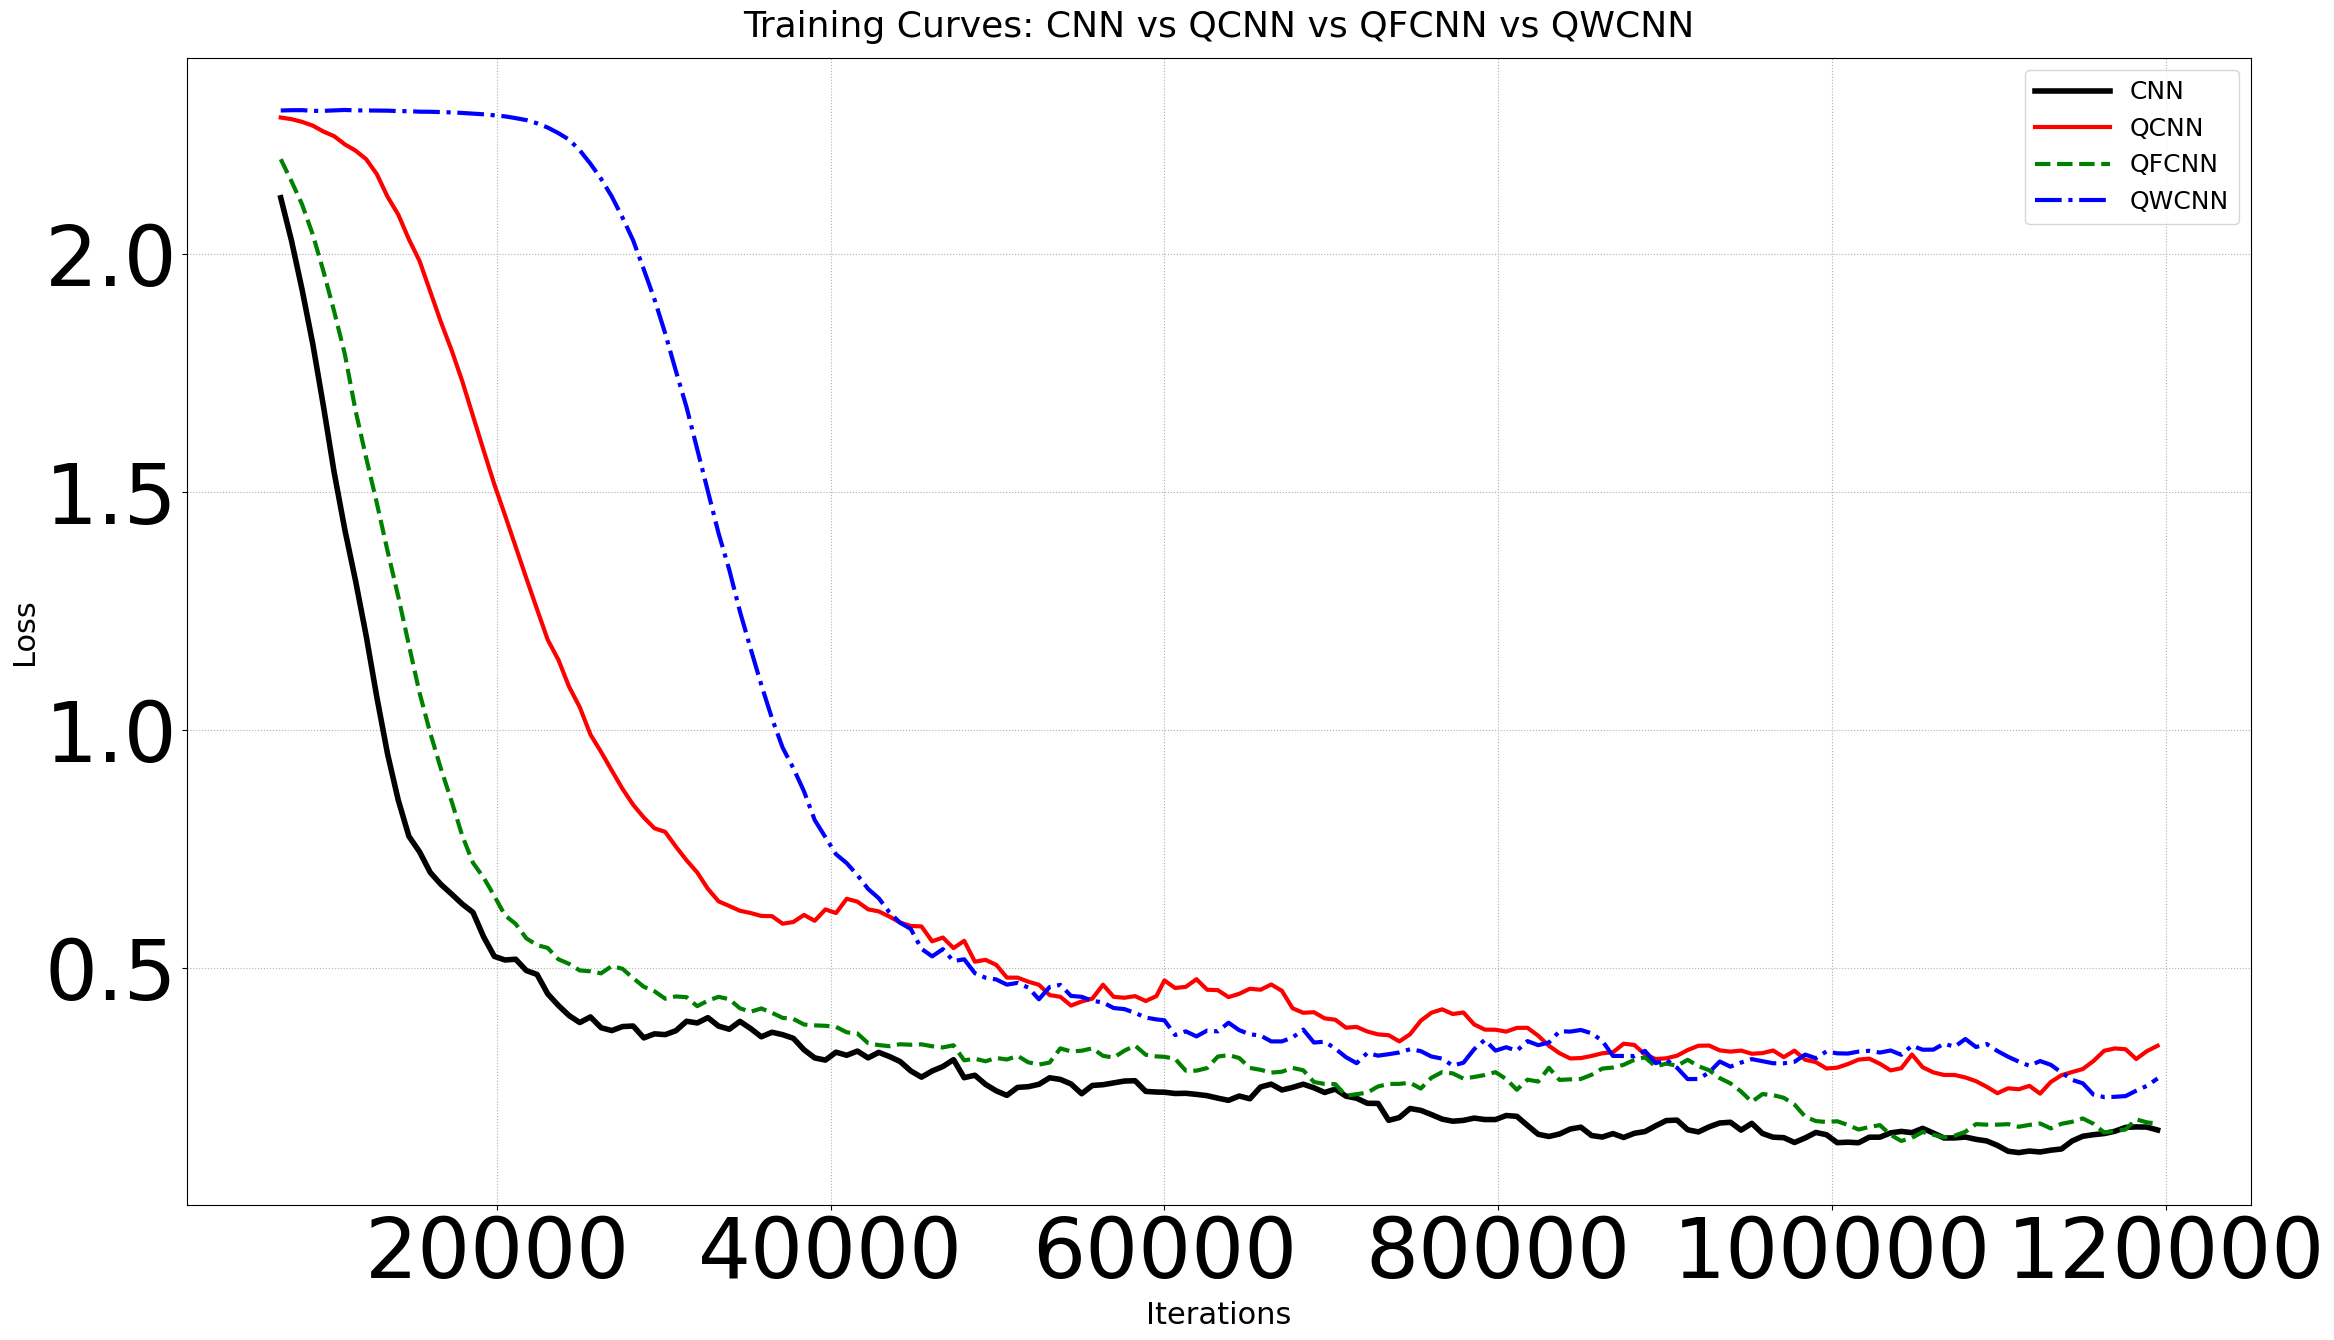

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = False

# ✅ 기본 설정
window = 12
all_data = pd.DataFrame()
name_list = []
i = 0

# ✅ 1️⃣ QCNN 결과 불러오기
for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:
                name = f'QCNN_ratio-{ratio}_epsilon-{epsilon}_Cap-{Cap}_BackpErr_{BackpErr}'
                if os.path.isfile(path + f'traincurve_{name}.csv'):
                    df_train = pd.DataFrame()
                    df_train[name] = pd.read_csv(path + f'traincurve_{name}.csv', index_col='counter')['losses']
                    df_train[f'rollmean_{name}'] = df_train[name].rolling(window=window).mean()
                    all_data = pd.concat([all_data, df_train], axis=1)
                    name_list.append(name)
                    i += 1

# ✅ 2️⃣ QFCNN 결과 불러오기
for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:
                name = f'QFCNN_ratio-{ratio}_epsilon-{epsilon}_Cap-{Cap}_BackpErr_{BackpErr}'
                if os.path.isfile(path + f'traincurve_{name}.csv'):
                    df_train = pd.DataFrame()
                    df_train[name] = pd.read_csv(path + f'traincurve_{name}.csv', index_col='counter')['losses']
                    df_train[f'rollmean_{name}'] = df_train[name].rolling(window=window).mean()
                    all_data = pd.concat([all_data, df_train], axis=1)
                    name_list.append(name)
                    i += 1

# ✅ 3️⃣ QWCNN 결과 불러오기 (🔵 새로 추가)
for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:
                name = f'QWCNN_ratio-{ratio}_epsilon-{epsilon}_Cap-{Cap}_BackpErr_{BackpErr}'
                if os.path.isfile(path + f'traincurve_{name}.csv'):
                    df_train = pd.DataFrame()
                    df_train[name] = pd.read_csv(path + f'traincurve_{name}.csv', index_col='counter')['losses']
                    df_train[f'rollmean_{name}'] = df_train[name].rolling(window=window).mean()
                    all_data = pd.concat([all_data, df_train], axis=1)
                    name_list.append(name)
                    i += 1

# ✅ 4️⃣ CNN baseline
df_train = pd.DataFrame()
name = 'CNN'
df_train[name] = pd.read_csv(path + f'traincurve_{name}.csv', index_col='counter')['losses']
df_train[f'rollmean_{name}'] = df_train[name].rolling(window=window).mean()
all_data = pd.concat([all_data, df_train], axis=1)

print(f"\n---- 총 {i}개의 실험 결과 로드 완료 ----")

# ✅ 5️⃣ 플로팅 (색상/라인 구분)
plt.figure(figsize=(25, 15))
plt.plot(all_data['rollmean_CNN'], color='black', label='CNN', linewidth=4)

LINESTYLE = ["-", "--", "-.", ":"]
color = plt.cm.get_cmap('hsv', 50)

for count, name in enumerate(name_list):
    if 'QCNN' in name:
        plt.plot(all_data[f'rollmean_{name}'], color='red', linestyle=LINESTYLE[count % len(LINESTYLE)], linewidth=3, label='QCNN' if 'QCNN' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif 'QFCNN' in name:
        plt.plot(all_data[f'rollmean_{name}'], color='green', linestyle=LINESTYLE[count % len(LINESTYLE)], linewidth=3, label='QFCNN' if 'QFCNN' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif 'QWCNN' in name:
        plt.plot(all_data[f'rollmean_{name}'], color='blue', linestyle=LINESTYLE[count % len(LINESTYLE)], linewidth=3, label='QWCNN' if 'QWCNN' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend(loc='upper right', fontsize=18)
plt.title('Training Curves: CNN vs QCNN vs QFCNN vs QWCNN', fontsize=26, pad=15)
plt.xlabel('Iterations', fontsize=22)
plt.ylabel('Loss', fontsize=22)
plt.grid(True, linestyle=':')
plt.tight_layout()

fname = f'./images/training_comparison_QFCNN_QWCNN_all.png'
plt.savefig(fname, dpi=300)
plt.show(block=False)

